# Übungsblatt 3 (Regression) - Grundkonzepte der Datenanalyse und Visualisierung WS 2024/25

Ziel dieses Übungsteils ist es, selbst Regressionsmodelle zu erstellen. Um den Übungsteil zeitlich im Rahmen zu halten haben wir ein Beispiel mit sehr wenigen Merkmalen gewählt - deren Werte auch bereits für eine Regression geeignet sind. In der Praxis spielt die Auswahl und Aufbereitung relevanter Parameter eine wichtige Rolle. Es ist daher sinnvoll, nach der ersten Analyse der Daten (Abschnitt 1) zumindest kurz darüber zu reflektieren, welche Vermutungen sich über den Einfluss der Paramter auf das Ergebnis treffen lassen - und warum.

Das Übungsblatt besteht aus den folgenden Teilen:

- Erste Analyse der Daten
- Einfache lineare Regression
- Multiple lineare Regression
- Polynomielle Regression

Wenig überraschend beginnen wir zu allererst mit den nötigen Imports

In [55]:
# Grafiken im Notebook anzeigen
%matplotlib inline

# Standardbibliotheken:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# Für einige Testfälle
import numpy.testing

# scikit-learn Importe: ML/Regressionsmodelle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures

# Hilfsmittel
from sklearn.model_selection import train_test_split

# ein paar Hilfsfunktionen um bei unterschiedlichen Lösungswegen die selbe Ausgabe zu erzeugen:
coeff_val = lambda c : c[0] if type(c) == np.ndarray else c

## Datensatz: Bewilligungen und Fertigstellungen von Wohnungen in Österreich

Unser Ziel ist es, ein Regressionsmodell zu erstellen, welches den Zusammenhang zwischen den jährlichen Baubewilligungen für neue Wohnungen sowie der Zahl an fertiggestellten Wohnungen beschreibt. Es ist davon auszugehen, dass die Fertigstellungen von den Bewilligungen abhängen - nicht so klar ist (zumindest für das LVA-Team :-) ), wie diese Abhängigkeit aussieht: Wohnungen zu bauen dauert Zeit - das heißt die Fertigstellungen in einem Jahr werden eher von den Bewilligungen der vergangenen Jahr abängen, als von jenen des aktuellen Jahres. Wie diese Abhängigkeit genau aussieht hängt unter anderem von der Fertigstellungsdauer ab - und davon, wie viele bewilligte Bauten überhaupt fertig gestellt werden. Die Hauptfragen, zu denen wir versuchen werden Indizien in den Daten zu finden, sind die Fragen: 
* Können wir eine ungefähre mittlere Bauzeit (bzw. Zeit zwischen Bewilligung und Fertigstellung) aus den Daten abschätzen?
* Können wir, gegeben die Anzahl an Bewilligungen der letzten Jahre, abschätzen wie viele Wohnungen im nächsten/in den nächsten Jahren fertiggestellt werden?
* Wie wir sehen werden, gibt es eine Lücke in der Abdeckung der Daten. Können wir die Werte für die fehlenden Jahre interpolieren?

Die reduzierte Anzahl an Merkmalen des Datensatzes grenzt natürlich auch die Anzahl der möglichen Fragestellungen ein. Die Hinzunahme weiterer Merkmale (Bevölkerungsentwicklung, Wohnungspreise, weitere Wirtschaftskennzahlen) würde weitere Fragestellungen erlauben (z.B: "können wir die Anzahl der erwarteten _Bewilligungen_ abschätzen", "beeinflussen äußere Faktoren die Dauer zwischen Bewilligung und Fertigstellung"). Aufgrund des zeitlichen Rahmens beschränken wir uns jedoch auf die beiden genannten Merkmale.

**Beschreibung der Daten:**

* __Jahr__ Die Jahreszahl des Jahres aus dem die Daten stammen
* __Fertigstellungen__ Die Anzahl der in diesem Jahr als fertiggestellt gemeldeten Wohnungen
* __Bewilligung__ Die Anzahl der in diesem Jahr bewilligten neuen Wohnungen (Baubewilligungen)

**Quelle:**

Die Daten stammen alle von der [Statistik Austria](https://www.statistik.at). Leider ist die Datenlage etwas unübersichtlich: Von 1980-2002 gibt es die Wohnbaustatistik im StatCube [Extern V9/Statistiken/Wohnungen, Gebäude/Errichtung von Gebäuden und Wohnungen/Neue Wohnungen 1980-2002 (Wohnbaustatistik)]. 
In den Folgejahren fehlte die gesetzliche Grundlage zum Sammeln der Daten, weshalb die Statistik erst später wieder weiter geht. Leider gibt es aufgrund der genauen Zählweise und welche Wohnungen inkludiert wurden und welche nicht für die späteren Jahre auch leicht abweichende Zahlen. Jene Werte, die auch am besten zu anderen veröffentlichten Berichten passen, sind jene aus den Aufstellungen [hier (Fertigstellungen)](https://www.statistik.at/fileadmin/pages/353/Whg05-22_Bdl_150923.ods) und [hier (Bewilligungen)](https://www.statistik.at/fileadmin/pages/352/WhgQ10-Q24_150623_150624_Q1.ods) (bitte beachten Sie, dass wir auf dem Gebiet des Bauens nicht einmal Laien sind - sollte uns hier ein Fehler oder eine Missinterpretation unterlaufen sein, der Ihnen auffällt, freuen wir uns wenn Sie uns darauf aufmerksam machen. Der eigentliche Zweck der Übung - das Erstellen und Interpretieren von Regressionsmodellen - ist mit diesen Daten aber abgedeckt, selbst wenn sie falsch sein sollten). 

Wir haben diese Daten in einem Datensatz vereint, welcher für die Jahre 2003 und 2004 eine Lücke aufweist.

**Hinweis:** 

Auch wenn wir die Daten nach bestem Wissen und Gewissen aus einer offiziellen Quelle zusammengezogen haben, sollten Sie daraus keine Rückschlüsse, Entscheidungen oder Meinungen über die dargestellte Sache ziehen. Ziel der Daten ist das Erstellen und Interpretieren von Regressionsmodellen.

In [56]:
# Wir laden den Datensatz
flats_at = 'WohnungsbauOesterreich.csv'

df_flats_raw = pd.read_csv(flats_at, sep=';')

df_flats_raw

,Jahr,Fertigstellung,Bewilligung
0,1980,73251,42334
1,1981,47345,41292
2,1982,40847,37516
3,1983,35918,36958
4,1984,37645,36263
5,1985,37317,30568
6,1986,34616,28483
7,1987,34289,30338
8,1988,34893,30348
9,1989,32858,31946


### Aufbereiten der Daten

Leider stellt sich die Situation in den wenisgten Fällen so dar, dass es bereits einen Datensatz gibt welcher so aufbereitet ist, dass wir sofort mit der Analyse der Daten beginnen können. Wir haben mögliche Vorbereitungssschritte bereits in den letzten Übungsblättern angedeutet, und wie am Beginn dieses Notebooks beschrieben, wurde der Inhalt des vorliegenden Datensatzes bereits aus mehreren Quellen zusammengefügt. Trotzdem benötigen wir noch eine letzte Aufarbeitung der Daten. Der nötige Schritt ist bereits fertig implementiert, wir haben aber beschlossen ihn als Teil des Notebooks zu veröffentlichen und nicht bereits in den geladenen Daten. Sie können sich die Implementierung ansehen, oder auch einfach ignorieren. Bitte die entsprechende Zellen aber ausführen.

Wie bereits angemerkt, ist davon auszugehen, dass die Fertigstellungen in einem Jahr weniger von den Bewilligungen im selben Jahr abhängen, sondern von den Bewilligungen der vergangenen Jahre. Um diese Hypothese zu testen - und im Falle, dass sie sich als korrekt herausstellt, auch ausnützen zu können - und gleichzeitig die in der Vorlesung vorgestellten Methoden anwenden zu können, werden wir den Datensatz etwas anpassen:

Zusätzlich zu den drei Merkmalen **Jahr**, **Fertigstellungen** und **Bewilligungen** fügen wir vier weitere Merkmale ein: 
- **Bewilligungen vor 1 Jahr**
- **Bewilligungen vor 2 Jahren**
- **Bewilligungen vor 3 Jahren**
- **Bewilligungen vor 4 Jahren**

Es sind mehree Vorgehensweisen denkbar, wir haben uns für eine (hoffentlich) leicht nachvollziehbare Variante entschieden: 

In [57]:
# Um die "Lücke" der fehlenden Werte für 2003 und 2004 zu behandeln, teilen wir den Datensatz in zwei DataFrames auf
part_1 = df_flats_raw[df_flats_raw["Jahr"] < 2003].copy()      # ein DF mit den Werten bis inkl. 2002
part_2 = df_flats_raw[(df_flats_raw["Jahr"] > 2003)].copy()    # ein DF mit den restlichen Werten

years = 4

# wir fügen jedem der beiden DataFrames die neuen Merkmale hinzu. 
# wir verwenden dazu die shift-Methode: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html 
# (diese "verschiebt" die Werte der Spalte um jeweils eine Zeile "nach oben"
for j in range(1, years+1):
    part_1[f"Bewilligungen vor {j} Jahren"] = part_1["Bewilligung"].shift(j)
    part_2[f"Bewilligungen vor {j} Jahren"] = part_2["Bewilligung"].shift(j)

# Für die ersten 4 Einträge in jedem DataFrame haben wir Lücken in den Bewilligungen der 4 Jahre zuvor. 
# Wir entfernen diese Einträge, so dass wir nur Jahre im DataFrame haben, für welche die Bewilligungen 
# in allen 4 vorangegangenen Jahren bekannt sind.
part_1 = part_1.iloc[years:]
part_2 = part_2.iloc[years:]

# Wir vereinen den Inhalt der beiden DataFrames wieder zu einem einzigen DataFrame und räumen auf.
df_flats = pd.concat([part_1, part_2])
df_flats.reset_index(inplace=True)
df_flats.drop("index", axis=1, inplace=True)
df_flats.rename(columns={"Bewilligungen vor 1 Jahren": "Bewilligungen vor 1 Jahr"}, inplace=True)
df_flats = df_flats.astype('int64')

df_flats

,Jahr,Fertigstellung,Bewilligung,Bewilligungen vor 1 Jahr,Bewilligungen vor 2 Jahren,Bewilligungen vor 3 Jahren,Bewilligungen vor 4 Jahren
0,1984,37645,36263,36958,37516,41292,42334
1,1985,37317,30568,36263,36958,37516,41292
2,1986,34616,28483,30568,36263,36958,37516
3,1987,34289,30338,28483,30568,36263,36958
4,1988,34893,30348,30338,28483,30568,36263
5,1989,32858,31946,30348,30338,28483,30568
6,1990,31335,29987,31946,30348,30338,28483
7,1991,34312,34414,29987,31946,30348,30338
8,1992,34334,41548,34414,29987,31946,30348
9,1993,35494,48231,41548,34414,29987,31946


Wir mussten unseren - bislang schon nicht sehr umfangreichen - Datensatz zwar gerade um 8 Einträge kürzen, aber damit ist es leider noch immer nicht getan. Um zumindest eine ungefähre Abschätzung der Qualität unseres Modells zu erhalten, müssen wir nun auch noch Testdaten aus dem Datensatz entnehmen, welche wir nicht zum Training des Modells verwenden werden. 

Der Code dazu ist bereits vorgegeben:

In [58]:
df_flats_train, df_flats_test = train_test_split(df_flats, test_size=0.25, random_state=202410, shuffle=True)
df_flats_train.sort_values("Jahr", inplace=True)

df_flats_train

,Jahr,Fertigstellung,Bewilligung,Bewilligungen vor 1 Jahr,Bewilligungen vor 2 Jahren,Bewilligungen vor 3 Jahren,Bewilligungen vor 4 Jahren
1,1985,37317,30568,36263,36958,37516,41292
3,1987,34289,30338,28483,30568,36263,36958
4,1988,34893,30348,30338,28483,30568,36263
5,1989,32858,31946,30348,30338,28483,30568
6,1990,31335,29987,31946,30348,30338,28483
7,1991,34312,34414,29987,31946,30348,30338
8,1992,34334,41548,34414,29987,31946,30348
9,1993,35494,48231,41548,34414,29987,31946
13,1997,48436,46196,53629,54515,50514,48231
14,1998,47378,41722,46196,53629,54515,50514


_Hinweis:_ Wir stehen hier vor einer in der Praxis sehr häufig auftretenden Situation: Eigentlich würden wir einen größeren Datensatz benötigen, um uns unsere Methoden wirklich zuverlässig anwenden zu können. Es stehen uns aber einfach nicht mehr Daten zur Verfügung. Wir werden unser Modell am Ende auch noch auf ungesehenen Daten evaluieren, daher können wir für den Moment damit leben.

## Daten analysieren

Der erste Schritt bei der Entwicklung von Modellen ist das Erlangen eines grundlegenden Verständnisses der Daten.
Generell ist unser Ziel die Anzahl an Fertigstellungen zu beschreiben/vorherzusagen. 

Betrachten Sie daher die **Trainingsdaten** (die Testdaten kommen in diesem Schritt nicht zum Einsatz), und analysieren Sie diese mit den bereits in den ersten beiden Übungen eingesetzten Methoden.
Versuchen Sie, einen grundlegenden Überblick über die Daten zu erhalten, und überlegen Sie sich, welche Merkmale (bzw. Kombinationen von Merkmalen) gut zur Beschreibung/Vorhersage der Fertigstellungen geeignet sein könnten, und welche weniger. Vielleicht lässt sich sogar schon eine ungefähre durchschnittliche Fertigstellungsdauer abschätzen?
Sie dürfen hier ganz grundlegend beginnen den Datensatz zu betrachen - beachten Sie, dass wir uns bislang noch gar nichts über den Datensatz angeschaut haben.

Diese Aufgabe gliedert sich in zwei Teile:
1. Für den ersten Teil gibt es keine konkreten Vorgaben. Erzeugen Sie jedoch zumindest in jeder der vorgegebenen Zellen eine sinnvolle Ausgabe zur Analyse der Daten (Sie dürfen dabei natürlich ganz simpel beginnen).
2. Beantworten Sie die anschließend gestellten Fragen.

In [59]:
df_flats_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23 entries, 1 to 30
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   Jahr                        23 non-null     int64
 1   Fertigstellung              23 non-null     int64
 2   Bewilligung                 23 non-null     int64
 3   Bewilligungen vor 1 Jahr    23 non-null     int64
 4   Bewilligungen vor 2 Jahren  23 non-null     int64
 5   Bewilligungen vor 3 Jahren  23 non-null     int64
 6   Bewilligungen vor 4 Jahren  23 non-null     int64
dtypes: int64(7)
memory usage: 1.4 KB


In [60]:
correlation_matrix = df_flats_train.corr()
correlation_matrix_fertigstellung = correlation_matrix.loc['Fertigstellung']
print(correlation_matrix_fertigstellung)
highest_corr = correlation_matrix_fertigstellung.drop(labels=['Fertigstellung']).idxmax()
print("The highest correletion: ", highest_corr, correlation_matrix_fertigstellung[highest_corr])

Jahr                          0.839331
Fertigstellung                1.000000
Bewilligung                   0.878155
Bewilligungen vor 1 Jahr      0.943737
Bewilligungen vor 2 Jahren    0.964626
Bewilligungen vor 3 Jahren    0.940418
Bewilligungen vor 4 Jahren    0.930239
Name: Fertigstellung, dtype: float64
The highest correletion:  Bewilligungen vor 2 Jahren 0.9646255256978082


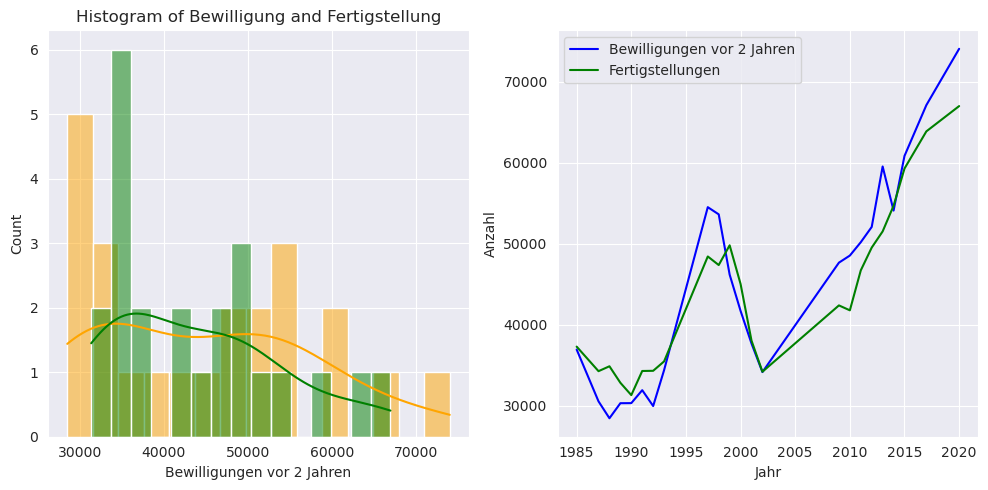

In [61]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.histplot(x=df_flats_train['Bewilligungen vor 2 Jahren'], bins=15, kde=True, color='orange')
sns.histplot(x=df_flats_train['Fertigstellung'], bins=15, kde=True, color='green')
plt.title('Histogram of Bewilligung and Fertigstellung')

plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(df_flats_train['Jahr'], df_flats_train['Bewilligungen vor 2 Jahren'], 'b', label='Bewilligungen vor 2 Jahren')
plt.plot(df_flats_train['Jahr'], df_flats_train['Fertigstellung'], 'g', label='Fertigstellungen')
plt.xlabel('Jahr')
plt.ylabel('Anzahl')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [62]:
print('Die Anzahl der Fertigstellungen: ', df_flats_train['Fertigstellung'].sum())
differences = df_flats_train.apply(lambda x: abs(df_flats_train['Fertigstellung'] - x))
differences = differences.drop(columns=['Fertigstellung', 'Jahr'])
sum_differences = differences.sum()
min_differences = sum_differences.min()
closest_column = sum_differences.idxmin()
min_difference_value = sum_differences[closest_column]

print(f"Min Differenz mit 'Fertigstellung': '{closest_column}', die Differenz: {min_difference_value}")

Die Anzahl der Fertigstellungen:  1014562
Min Differenz mit 'Fertigstellung': 'Bewilligungen vor 2 Jahren', die Differenz: 79961


Beantworten Sie nun die folgende Frage:

- Wenn Sie die Fertigstellungen anhand eines einzelnen "Bewilligungs"-Merkmals entscheiden müssten (selbe Jahr, vor 1 Jahr, ..., vor 4 Jahren), für welches Jahr (0-4) würden Sie sich entscheiden - und warum?

Verwenden Sie die nächste Zelle, um Ihre Wahl bekannt zu geben, sowie die darauf folgende Zelle um Ihre Begründungen abzugeben. 
Als Begründungen reicht ein kurzer (!) Satz.

In [63]:
## Weisen Sie bitte der Variablen 'jahre' die Anzahl an Jahren zu, die Sie zurückschauen würden (Zahl von 0-4)

jahre = 2

print(f'#### Meine Wahl:\n {jahre} JAHRE')

#### Meine Wahl:
 2 JAHRE


Begründung für die Wahl der Jahre:

Ich wähle den Indikator 'Bewilligungen vor 2 Jahren', da er
- die höchste Korrelation mit den fertiggestellten Wohnungen aufweist
- die geringste Differenz zwischen der Anzahl bewilligter und fertiggestellter Wohnungen zeigt.

In [64]:
assert 0 <= jahre <= 4


## Einfache Lineare Regression

In diesem Schritt würden nun typischerweise viele verschiedene Modelle mit verschiedenen Ansätzen und Merkmalen erstellt werden, um verschiedene Theorien darüber, wie gut unterschiedliche Merkmale den gewünschten Zielwert beschreiben, zu evaluieren. Um den Umfang des Übungsblattes nicht überzustrapazieren werden wir uns hier auf ein paar wenige Merkmale konzentrieren.

Um einmal selber eine Regression erstellt zu haben, betrachten wir zuerst das Merkmal **Bewilligung**, also die im selben Jahr bewilligten Wohnungen, und verwenden dieses Merkmal um die Werte von **Fertigstellung** zu beschreiben. 

Dazu arbeiten wir folgende Schritte ab:
- Erstellen eines Modells
- Berechnung des Fehlers des Modells

Später werden wir noch zwei weitere Punkte angehen:
- Analyse des Fehlers des Modells
- Visualisierung des Modells

<br/>

### Erstes Modell

Erstellen Sie ein einfaches lineares Regressionsmodell, welches den Wert von **Fertigstellung** anhand des Merkmals **Bewilligung** beschreibt/vorhersagt.

In [65]:
## Erstellen Sie ein einfaches lineares Regressionsmodell 
## (unabhängiges Merkmal: "Bewilligung", abhängiges Merkmal: "Fertigstellung")
## und speichern Sie einen Verweis auf dieses Modell in der Variablen 'sreg_first'
## Verwenden Sie anschließend die Trainingsdaten aus 'df_flats_train' um die 
## Parameter des Modells für die gewünschte Vorhersage einzustellen


# es ist häufig guter Programmierstil, im Code selber keine konstanten Werte zu verwenden, sondern diese zentral zu definieren
indi_feature = "Bewilligung"
predict_feature = "Fertigstellung"


sreg_first = LinearRegression(fit_intercept=True)
df_indep = df_flats_train[[indi_feature]]
sreg_first.fit(X=df_indep, y=df_flats_train[predict_feature])

# Wir lesen die Regressionsgerade aus:
print(f'Regressionsgerade f(x) = {coeff_val(sreg_first.coef_[0])} * x + {coeff_val(sreg_first.intercept_)}')

sreg_first

Regressionsgerade f(x) = 0.557377656235416 * x + 17971.66361889727


LinearRegression()

In [66]:
# Ein paar simple Testfälle
assert sreg_first is not None
assert abs(coeff_val(sreg_first.coef_[0])) > 0    
assert abs(coeff_val(sreg_first.intercept_)) > 1000  

# Wir testen zwei Vorhersagen
val = lambda v, t: [v] if type(t) == np.ndarray else v
test_data = pd.DataFrame(data={indi_feature: [31946, 60835]})
predictions = sreg_first.predict(test_data)
assert (predictions > [val(35000, predictions[0]), val(50000, predictions[0])]).all(), \
        f'Vorhersagen kleiner als erwartet: {predictions} > [35000, 50000]'



Zur Evaluierung des Modells berechnen wir den R$^2$ Score sowohl für die Trainings- als auch die Testdaten, und vergleichen beide miteinander.

In [67]:
## Berechnen Sie den R^2 Wert für die Trainingsdaten und speichern Sie den Wert in der Variablen
##   'r2_training_first'

fx = sreg_first.predict(df_indep)
r2_training_first = r2_score(y_true=df_flats_train["Fertigstellung"], y_pred=fx)

print(f'R^2 Score auf den Trainingsdaten: {r2_training_first}')

R^2 Score auf den Trainingsdaten: 0.7711564476519542


In [68]:
## Berechnen Sie den R^2 Wert für die Testdaten und speichern Sie den Wert in der Variablen
##   'r2_test_first'

fx = sreg_first.predict(df_flats_test[[indi_feature]])
r2_test_first = r2_score(y_true=df_flats_test["Fertigstellung"], y_pred=fx)

print(f'R^2 Score auf den Trainingsdaten: {r2_training_first}')
print(f'R^2 Score auf den Testdaten:      {r2_test_first}')

R^2 Score auf den Trainingsdaten: 0.7711564476519542
R^2 Score auf den Testdaten:      0.8863092264456566


In [69]:
# ein paar grundlegende Testfälle
assert 0 < r2_training_first < 1
assert 0 < r2_test_first < 1

# soviel sei verraten:
assert r2_training_first > 0.7
assert r2_test_first > 0.7    



Vergleichen Sie die beiden Fehler, und überlegen Sie sich, ob die Werte für ein Overfitting des Modells sprechen, oder eher nicht.

(Keine Eingabe/Abgabe erforderlich)

### Welche Bewilligungen geben den besten Wert?

Da es meist länger als ein Jahr dauert, eine Wohnung zu bauen, ist davon auszugehen, dass die Bewilligungen in einem Jahr nicht wirklich etwas darüber aussagen, wie viele Wohnungen im selben Jahr auch fertig gestellt wurden (der Zusammenhang, den das vorherige Modell gefunden hat, ergibt sich vermutlich eher daraus, dass wir in der initialien Analyse (hoffentlich ;-) ) festgestellt haben, dass die Anzahl der Bewilligungen von einem Jahr auf das nächste Jahr nicht so stark abweichen, sondern eine starke Korrelation zwischen diesen Werten existiert). Wie angekündigt interessieren wir uns dafür, wie weit wir bei den Bewilligungen zurück gehen müssen, um die beste Vorhersage für die Anzahl der fertiggestellten Wohnungen zu erreichen - was uns auch eine Abschätzung für die durchschnittliche Baulänge geben würde. 

Um das zu tun, erstellen wir nun je ein lineares Regressionsmodell für die Bewilligungen von 1 bis 4 Jahren zuvor, und betrachten die Resultate dieser Modelle sowohl auf den Trainings- als auch auf den Testdaten. 

_Hinweis:_ Sie können dies natürlich lösen, indem Sie den Code von zuvor einfach 4 mal kopieren und die Werte ändern. Im Sinne der Datenanalyse ist das Ergebnis korrekt. Damit Sie es selber etwas leichter haben, würden wir aber nicht empfehlen vier mal den gleichen Code zu kopieren, sondern mit einer Schleife und/oder Funktion zu arbeiten.

In [70]:
## Erstellen Sie vier einfache lineare Regressionsmodelle, je eines für 
## die unabhängigen Merkmale:
##   "Bewilligungen vor 1 Jahr", 
##   "Bewilligungen vor 2 Jahren", 
##   "Bewilligungen vor 3 Jahren", und
##   "Bewilligungen vor 4 Jahren"
## Das abhängige Merkmal ist jedes mal: "Fertigstellung"
## Verwenden Sie die Daten in 'df_flats_train' um die Parameter der Modelle 
## einzustellen.
##
## Speichern Sie die Modelle in der in 'sreg_models' initialisierten Liste.
## Die Reihenfolge muss jener der Merkmale in der obigen Aufzählung entsprechen.
##
## Berechnen Sie für jedes Modell den R2-Score sowohl auf den Trainings- als 
## auch auf den Testdaten.
## 
## Speichern Sie den höchsten erreichten R2-Score auf den Test(!)daten in der
## Variablen 'best_score', und den Index von 'sreg_models', an dem das zugehörige
## Modell liegt, in 'best_model_idx'. (sreg_models[best_model_idx] sollte also 
## Zugriff auf das beste Modell geben)
## 
## Geben Sie für jedes Modell folgene Informationen aus:
## - die Regressionsgleichung (Sie können die Funktion 'print_equation' dazu verwenden)
## - den R2-Score auf den Trainingsdaten (mittels print)
## - den R2-Score auf den Testdaten (mittels print)


indi_features = ["Bewilligungen vor 1 Jahr", 
                 "Bewilligungen vor 2 Jahren",
                 "Bewilligungen vor 3 Jahren",
                 "Bewilligungen vor 4 Jahren"]

sreg_models = []
best_model_idx = -1
best_score = -1

def print_equation(model):
    print(f'Regressionsgerade f(x) = {coeff_val(model.coef_[0])} * x + {coeff_val(model.intercept_)}')
    
for feature in indi_features:
    sreg = LinearRegression()  # Create a new instance of the regression model
    sreg.fit(X=df_flats_train[[feature]], y=df_flats_train[predict_feature])
    sreg_models.append(sreg)  # Append the fitted model to the list

for model in sreg_models:
    print_equation(model)

fxs_train = []
fxs_test = []

# Use zip to iterate over both models and features together
for model, feature in zip(sreg_models, indi_features):
    fxs_train.append(model.predict(df_flats_train[[feature]]))
    fxs_test.append(model.predict(df_flats_test[[feature]]))

r2_scores_train = [r2_score(y_true=df_flats_train["Fertigstellung"], y_pred=fx) for fx in fxs_train]
r2_scores_test = [r2_score(y_true=df_flats_test["Fertigstellung"], y_pred=fx) for fx in fxs_test]
best_score = max(r2_scores_test)
best_model_idx = r2_scores_test.index(best_score)

print(f'\n\nBester Score: {best_score} an Index {best_model_idx}')

Regressionsgerade f(x) = 0.6338678256672204 * x + 14909.789562626007
Regressionsgerade f(x) = 0.7557601793137539 * x + 10099.390208479257
Regressionsgerade f(x) = 0.7044459400830921 * x + 11932.14762093042
Regressionsgerade f(x) = 0.8287574934389522 * x + 6340.083915112125


Bester Score: 0.9426742014026187 an Index 1


In [71]:
assert len(sreg_models) == 4, f'sreg_models enthält unerwartete Anzahl an Modellen: {len(sreg_models)} statt 4'
assert 0 <= best_model_idx < len(sreg_models), f'Index in best_model_idx kein gültiger Index von sreg_models. Index: {best_model_idx}; Länge: {len(sreg_models)}'
assert best_score > 0.9   # so viel sei verraten


Wenn Sie basierend auf diesen Ergebnissen eine Schätzung abgeben müssten, wie lange die Fertigstellung einer Wohnung im Schnitt dauert, was wäre Ihre Antwort - und warum? (Keine Eingabe notwendig)

Wir wollen nun ein bisschen besser verstehen, wie der R$^2$-Score zustande kommt. Dabei interessiert uns vor allem, wie sich die Fehler über die verschiedenen Jahre verteilen. Wir betrachten dabei nur das Modell mit dem besten R$^2$-Score.

In [72]:
# Sie können diese Variablen im weiteren verwenden, wenn Sie wollen. 
model = sreg_models[best_model_idx]
indi_feature = indi_features[best_model_idx]

### Fehler analysieren:

"Analysieren" ist vielleicht etwas hochgegriffen, aber wir wollen uns den Fehler für jedes der Jahre zumindest ausrechnen und anschauen. Dazu vergleichen wir für jedes Jahr (aus `df_flats`) die Anzahl der tatsächlich fertiggestellten Wohnungen mit der durch unser "bestes" Modell vorhergesagten Anzahl, indem wir die Werte berechnen und in einer Tabelle (DataFrame) gegenüberstellen. Um die Werte zu vergleichen berechnen wir weiters deren Differenz und die prozentuelle Abweichung der Vorhersage vom tatsächlichen Wert.

In [73]:
## Erstellen Sie ein DataFrame mit den Merkmalen (Spalten)
## - Jahr
## - Fertigstellung
## - Vorhersage 
## - Abweichung
## - Prozent
##
## Das DataFrame enthält einen Eintrag (Zeile) für jedes Jahr im DataFrame 'df_flats'.
## Die Merkmale sollen die folgenden Werte enthalten:
## - Jahr: Die entsprechende Jahreszahl
## - Fertigstellung: Die Anzahl der tatsächlichen Fertigstellungen in diesem Jahr (laut 'df_flats')
## - Vorhersage: Die Anzahl der durch das Modell* vorhergesagten Fertigstellungen für dieses Jahr
## - Abweichung: Der absolute Fehler der Vorhersage: die Differenz "Vorhersage"-"Fertigstellung"
## - Prozent: Wie viel Prozent die Abweichung von der tatsächlichen Anzahl an Fertigstellungen ausmacht (Vorzeichen wird von der Abweichung übernommen)
##
## *Werte sollen mit dem Modell aus 'sreg_models[best_model_idx]' berechnet werden - also mit jener Zeitspanne, welche den höchsten R2-Score ergab.
##
## Speichern Sie eine Referenz auf das DataFrame in der Variablen 'df_error'

df_error = pd.DataFrame()
df_error["Jahr"] = df_flats["Jahr"]
df_error["Fertigstellung"] = df_flats["Fertigstellung"]
df_error["Vorhersage"] = model.predict(df_flats[[indi_feature]])
df_error["Abweichung"] = df_error["Vorhersage"] - df_error["Fertigstellung"]
df_error["Prozent"] = abs(df_error["Abweichung"] / df_error["Fertigstellung"]) * 100

df_error

,Jahr,Fertigstellung,Vorhersage,Abweichung,Prozent
0,1984,37645,38452.489096,807.489096,2.145010
1,1985,37317,38030.774916,713.774916,1.912734
2,1986,34616,37505.521591,2889.521591,8.347358
3,1987,34289,33201.467370,-1087.532630,3.171666
4,1988,34893,31625.707396,-3267.292604,9.363748
5,1989,32858,33027.642528,169.642528,0.516290
6,1990,31335,33035.200130,1700.200130,5.425882
7,1991,34312,34242.904897,-69.095103,0.201373
8,1992,34334,32762.370706,-1571.629294,4.577472
9,1993,35494,36108.121019,614.121019,1.730211


In [74]:
assert (df_error[["Jahr", "Fertigstellung"]].sort_values("Jahr") == df_flats[["Jahr", "Fertigstellung"]].sort_values("Jahr")).all().all(),\
        f'df_error enthält nicht die erwarteten Jahre und tatsächlichen Fertigstellungen'
assert sorted(df_error.columns) == ['Abweichung', 'Fertigstellung', 'Jahr', 'Prozent', 'Vorhersage'], \
        f'df_error besitzt nicht die geforderten Merkmale: {sorted(df_error.columns)}'
assert int(df_error[df_error["Jahr"] == 2000]["Vorhersage"].iloc[0]) == 41631, \
        f'Unerwartete Vorhersage für 2000: {df_error[df_error["Jahr"] == 2000]["Vorhersage"].iloc[0]}'



Ein Blick auf die Tabelle zeigt, dass sich der Fehler pro Jahr tatsächlich in Grenzen hält (nur zwei mal über 10% der tatsächlichen Anzahl). 

Wir wollen vor allem wissen, wo der größte Fehler auftritt. 
Und auch wenn wir die Tabelle natürlich einfach manuell nach dem größten Fehler durchsuchen können, schneller und zuverlässiger ist es, wenn wir uns die Einträge ausrechnen und anzeigen lassen. 
Dabei interessieren uns sowohl die Fälle mit der größen absoluten Abweichung, als auch die Einträge mit der größten prozentuellen Abweichung.

_Achtung:_ Uns interessiert dabei der Abstand vom korrekten Wert. D.h. ein Fehler von -1000 ist größer als ein Fehler von +500, auch wenn -1000 die kleinere Zahl ist!

In [75]:
## Suchen Sie aus 'df_error' jene Jahre mit dem größten absoluten sowie dem größten relativen Fehler heraus.
## Erstellen Sie ein neues DataFrame mit den entsprechenden Einträgen (= jeweiligen Zeilen aus 'df_error'), 
## und speichern Sie eine Referenz auf dieses DataFrame in der Variablen `df_max_errors`.
## 
## Die Größe des Fehlers ist jeweils der Absolutbetrag des Fehlers (-1000 ist ein größerer Fehler als +500, 
## ebenso ist -10% der größere Fehler als +9%)
##
## WICHTIG: Lösen Sie das Problem so, dass Sie auch noch das richtige Ergebnis erhalten würden, wenn es mehrere
##          Zeilen mit dem maximalen Fehler geben würde (auch wenn es hier nicht der Fall ist).

df_max_errors = pd.DataFrame()

abs_max_error = df_error.iloc[df_error['Abweichung'].idxmax()]
proz_max_error = df_error.iloc[df_error['Prozent'].idxmax()]

df_max_errors = pd.concat([df_max_errors, abs_max_error.to_frame().T, proz_max_error.to_frame().T], ignore_index=True)
df_max_errors["Jahr"] = df_max_errors["Jahr"].astype(int)

df_max_errors

,Jahr,Fertigstellung,Vorhersage,Abweichung,Prozent
0,2019,67997.0,75330.562805,7333.562805,10.785127
1,2010,41793.0,46789.279634,4996.279634,11.954824


In [76]:
assert len(df_max_errors.index) == 2
assert len(df_max_errors[df_max_errors["Jahr"] >= 2016].index) == 1


### Visualisieren

Echte Zahlen und Tabellen sind zwar schön, aber es wird der Punkt kommen, an dem wir das Modell einer Person vorstellen müssen, die davon nichts hält. Darum visualisieren wir zum Abschluss der einfachen linearen Regression die Regressionsgerade sowie die tatsächlichen Werte aus Test-und Trainingsdaten in einem Scatterplot.

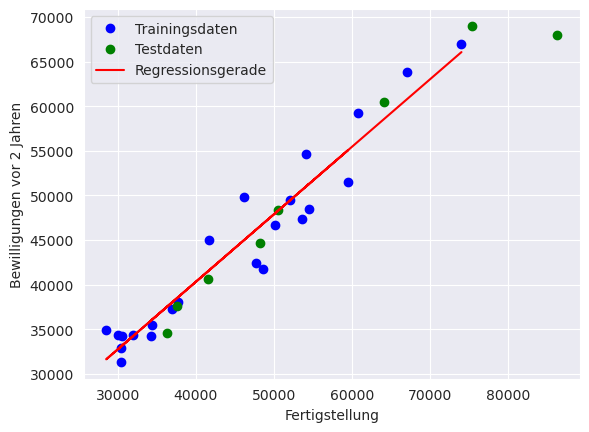

In [77]:
## Visualisieren Sie die Regressionsgerade* gemeinsam mit einem Scatterplot der beiden Merkmale
## ("Fertigstellung" auf der y-Achse und das gewählte ("beste") unabhängige Merkmal auf der x-Achse).
##
## Der Scatterplot soll sowohl die Trainings- als auch die Testdaten enthalten 
##  ('df_flats_train' bzw. 'df_flats_test').
## Verwenden Sie für 
## - die Regressionsgerade
## - die Trainingsdaten
## - die Testdaten
## jeweils unterschiedliche Farben.
##
## Speichern Sie eine Referenz auf den Plot in der Variable 'plot_linreg'
##
## *für das Modell aus 'sreg_models[best_model_idx]' 

plot_linreg = plt.plot(df_flats_train[indi_feature], df_flats_train["Fertigstellung"], 'bo', label='Trainingsdaten')
plot_linreg = plt.plot(df_flats_test[indi_feature], df_flats_test["Fertigstellung"], 'go', label='Testdaten')
plot_linreg = plt.plot(df_flats_train[indi_feature], coeff_val(model.coef_[0]) * df_flats_train[indi_feature] + coeff_val(model.intercept_), 'r', label='Regressionsgerade')
plot_linreg = plt.xlabel("Fertigstellung")
plot_linreg = plt.ylabel(indi_feature)
plot_linreg = plt.legend()

plot_linreg

In [78]:
# hier gibt es leider keine brauchbaren Testfälle 
assert plot_linreg is not None

assert True


## Multiple Lineare Regression

Bisher haben wir die Anzahl der fertiggestellten Wohnungen nur anhand der Genehmigungen eines Jahres beschrieben. Da es nicht anzunehmen ist, dass alle Wohnungen gleich lange von der Genehmigung bis zur Fertigstellung brauchen, ist davon auszugehen, dass die Anzahl der fertiggestellten Wohnungen eher von den Bewilligungen mehrerer Jahren abhängt, als nur von einem Jahr. Wir versuchen dies nun zu berücksichtigen, indem wir ein Modell erstellen, welches die Genehmigungen der letzten 4 Jahre inkludiert. 

Wir erstellen dazu ein multiples lineares Regressionsmodell über den Merkmalen **Bewilligung**, **Bewilligungen vor 1 Jahr**, **Bewilligungen vor 2 Jahren**, **Bewilligungen vor 3 Jahren** und **Bewilligungen vor 4 Jahren**.

_Hinweis:_ Die Analyse der Daten am Beginn des Notebooks hat (hoffentlich, falls Sie darauf nicht untersucht haben, sollten Sie das noch nachholen :-) ) gezeigt, dass es zwischen diesen Merkmalen teilweise eine recht starke Korrelation gibt. Oftmals versucht man, von sehr stark korrelierten Merkmalen nur eines in eine Multiple Lineare Regression aufzunehmen. Wir behalten uns die Tatsache, dass wir korrelierte Werte haben, zwar im Hinterkopf, verwenden die Merkmale aber trotzdem.

In [79]:
## Erstellen Sie ein lineares Regressionsmodell, und speichern Sie eine Referenz darauf 
## in der Variablen 'mreg_flats'
## Das Modell soll als unabhängige Merkmale die Attribute
## "Bewilligung", "Bewilligungen vor 1 Jahr", "Bewilligungen vor 2 Jahren", "Bewilligungen vor 3 Jahren",
## "Bewilligungen vor 4 Jahren" verwenden (in der gegebenen Reihenfolge)
## um wiederum den Wert "Fertigstellung" vorauszusagen/zu beschreiben.
##
## Speichern Sie dabei in einem DataFrame 'df_indi_values' die unabhängigen Merkmale aus den Trainingsdaten,
## und verwenden Sie dieses zum Anpassen der Parameter des Modells

indi_features = ["Bewilligung", 
                 "Bewilligungen vor 1 Jahr", 
                 "Bewilligungen vor 2 Jahren",
                 "Bewilligungen vor 3 Jahren",
                 "Bewilligungen vor 4 Jahren"]
predict_feature = "Fertigstellung"

df_indi_values = df_flats_train[indi_features]

mreg_flats = LinearRegression()
mreg_flats.fit(X=df_flats_train[[feature for feature in indi_features]], y=df_flats_train[predict_feature])


# Wir lesen das Regressionsmodell aus
for idx, feature in enumerate(df_flats_train[indi_features].columns):
    print(f'Koeffizient für {feature}: {mreg_flats.coef_[idx]}')
print("Additiver Term:", mreg_flats.intercept_)

Koeffizient für Bewilligung: 0.11954176737199351
Koeffizient für Bewilligungen vor 1 Jahr: 0.08300424637132592
Koeffizient für Bewilligungen vor 2 Jahren: 0.26411807355882067
Koeffizient für Bewilligungen vor 3 Jahren: -0.037372574594855185
Koeffizient für Bewilligungen vor 4 Jahren: 0.3828707650366211
Additiver Term: 7052.489004290081


In [80]:
assert len(df_indi_values.index) == 23, f'Unerwartete Anzahl an Daten: {len(df_indi_values.index)} statt 23'
assert (df_indi_values.columns == ["Bewilligung", 
                 "Bewilligungen vor 1 Jahr", 
                 "Bewilligungen vor 2 Jahren",
                 "Bewilligungen vor 3 Jahren",
                 "Bewilligungen vor 4 Jahren"]).all()


assert mreg_flats.coef_[0] > 0
assert mreg_flats.coef_[1] > 0
assert mreg_flats.coef_[2] > 0
assert mreg_flats.coef_[3] < 0
assert mreg_flats.coef_[4] > 0
assert mreg_flats.intercept_ > 1000


Interpretieren Sie die Koeffizienten. Lässt sich aus den Koeffizienten etwas ablesen - im Bezug auf unsere Frage nach der durchschnittlichen Fertigstellungsdauer oder allgemein? (Keine Eingabe notwendig)

### Evaluierung des Modells

Wir evaluieren das Modell wiederum anhand seines R$^2$-Scores, und suchen wiederum die Fälle mit dem größten Fehler.

Um zu sehen, ob die Hereinnahme zusätzlicher Parameter unser Modell tatsächlich verbessert hat, berechnen wir den R$^2$-Score sowohl für die Trainings- als auch die Testdaten

In [81]:
## Berechnen Sie den R^2 Wert des Models 'mreg_flats' sowohl für die Trainingsdaten
## als auch die Testdaten und speichern Sie die Werte in der Variablen 
## 'r2_mtraining' bzw. 'r2_mtest'

pred_train = mreg_flats.predict(df_flats_train[[feature for feature in indi_features]])
pred_test = mreg_flats.predict(df_flats_test[[feature for feature in indi_features]])

r2_mtraining = r2_score(y_true=df_flats_train["Fertigstellung"], y_pred=pred_train)
r2_mtest = r2_score(y_true=df_flats_test["Fertigstellung"], y_pred=pred_test)

print(f'R^2 Score auf den Trainingsdaten: {r2_mtraining}')
print(f'R^2 Score auf den Testdaten:      {r2_mtest}')

R^2 Score auf den Trainingsdaten: 0.9600598789162401
R^2 Score auf den Testdaten:      0.959676734297745


In [82]:
# ein paar grundlegende Testfälle
assert 0 < r2_mtraining < 1
assert 0 < r2_mtest  < 1

# soviel sei verraten:
assert r2_mtraining > 0.9
assert r2_mtest  > 0.9



Als nächstes berechnen wir wiederum für jedes Jahr die vorhergesagte Anzahl an Fertigstellungen und vergleichen diese direkt mit der tatsächlichen Anzahl.

In [83]:
## Erstellen Sie ein DataFrame der selben Struktur und mit dem entsprechenden 
## Inhalt wie das DataFrame 'df_error'. 
## Speichern Sie eine Referenz auf das neue DataFrame in der Variablen 
## 'df_merror'


df_merror = pd.DataFrame()
df_merror["Jahr"] = df_flats["Jahr"]
df_merror["Fertigstellung"] = df_flats["Fertigstellung"]
df_merror["Vorhersage"] = mreg_flats.predict(df_flats[[feature for feature in indi_features]])
df_merror["Abweichung"] = df_merror["Vorhersage"] - df_merror["Fertigstellung"]
df_merror["Prozent"] = abs(df_merror["Abweichung"] / df_merror["Fertigstellung"]) * 100

df_merror

,Jahr,Fertigstellung,Vorhersage,Abweichung,Prozent
0,1984,37645,39029.019316,1384.019316,3.676502
1,1985,37317,37885.330619,568.330619,1.522980
2,1986,34616,35554.948678,938.948678,2.712470
3,1987,34289,33911.814426,-377.185574,1.100019
4,1988,34893,33463.038168,-1429.961832,4.098134
5,1989,32858,32042.307793,-815.692207,2.482477
6,1990,31335,31075.795766,-259.204234,0.827204
7,1991,34312,32574.314076,-1737.685924,5.064368
8,1992,34334,33221.284871,-1112.715129,3.240855
9,1993,35494,36466.625864,972.625864,2.740254


Und auch hier suchen wir uns wieder die Jahre mit dem größten Fehler heraus:

In [84]:
## Suchen Sie aus dem DataFrame in 'df_merror' jene Jahre mit dem größten absoluten sowie dem größten relativen 
## Fehler heraus.
## Erstellen Sie ein neues DataFrame mit den entsprechenden Einträgen, und speichern Sie eine Referenz auf 
## dieses DataFrame in der Variablen 'df_mmax_errors' (für: multiple max errors - das doppel m ist kein Fehler).
## 
## Die Größe des Fehlers ist jeweils der Absolutbetrag des Fehlers (-1000 ist ein größerer Fehler als +500, 
## ebenso ist -10% der größere Fehler als +9%)
##
## WICHTIG: Lösen Sie das Problem so, dass Sie auch noch das richtige Ergebnis erhalten würden, wenn es mehrere
##          Zeilen mit dem maximalen Fehler geben würde (auch wenn es hier nicht der Fall ist).

df_mmax_errors = pd.DataFrame()

abs_mmax_error = df_error.iloc[df_merror['Abweichung'].idxmax()]
proz_mmax_error = df_error.iloc[df_merror['Prozent'].idxmax()]

if not abs_mmax_error.equals(proz_mmax_error):
    df_mmax_errors = pd.concat([df_mmax_errors, abs_mmax_error.to_frame().T, proz_mmax_error.to_frame().T], ignore_index=True)
else:
    df_mmax_errors = pd.concat([df_mmax_errors, abs_mmax_error.to_frame().T], ignore_index=True)

df_mmax_errors["Jahr"] = df_mmax_errors["Jahr"].astype(int)
df_mmax_errors

,Jahr,Fertigstellung,Vorhersage,Abweichung,Prozent
0,2010,41793.0,46789.279634,4996.279634,11.954824


In [85]:
assert (df_merror[["Jahr", "Fertigstellung"]].sort_values("Jahr") == df_flats[["Jahr", "Fertigstellung"]].sort_values("Jahr")).all().all(),\
        f'df_merror enthält nicht die erwarteten Jahre und tatsächlichen Fertigstellungen'
assert sorted(df_merror.columns) == ['Abweichung', 'Fertigstellung', 'Jahr', 'Prozent', 'Vorhersage'], \
        f'df_merror besitzt nicht die geforderten Merkmale: {sorted(df_merror.columns)}'
assert int(df_merror[df_error["Jahr"] == 2000]["Vorhersage"].iloc[0]) == 44093, \
        f'Unerwartete Vorhersage für 2000: {df_merror[df_merror["Jahr"] == 2000]["Vorhersage"].iloc[0]}'


assert len(df_mmax_errors.index) == 1
assert len(df_mmax_errors[df_mmax_errors["Jahr"] >= 2016].index) == 0


## Polynomielle Regression

Bislang sind wir davon ausgegangen, dass wir die Anzahl der Genehmigungen kennen, und haben versucht daraus die Anzahl der neuen Wohnungen abzuleiten. Wie jedoch am Beginn kurz diskutiert, gibt es in unseren Daten leider eine Lücke, da es hier zu einer Lücke in den gesetzlichen Regelungen kam, wodurch die entsprechenden Daten nicht gesammelt wurden/werden durften. Wir wollen nun probieren, diese Lücke zu "schließen", indem wir versuchen die Anzahl der Bewilligungen anhand des Jahres zu beschreiben.

Eigentlich bestand die Lücke nur aus den Jahren 2003 und 2004. Ab 2005 haben wir erneut die Daten. Diese Lücke von zwei Jahren hat uns jedoch dazu gezwungen, in den bisherigen Untersuchungen auch die Jahre 2005-2008 auszuschließen, da uns hier nicht die vollständigen Genehmigungen der letzten 4 Jahre zur Verfügung standen. Wir werden im Folgenden so tun, als ob die Lücke tatsächlich 2003-2008 wäre. Das heißt, wir werden basierend auf den Jahren in ```df_flats``` ein Modell erstellen (wobei wir den gesamten Datensatz als Trainingsdaten verwenden werden). Anschließend können wir unser Modell dann auf "neue" Daten (2003-2008) anwenden, wobei wir für einige dieser Jahre die korrekten Werte kennen, und somit unsere Vorhersagen überprüfen können - etwas das wir in der Realität normalerweise nicht tun können. 

_Hinweis:_ Wir hätten in unserem ursprünglichen Datensatz auch noch die Bewilligungen der Jahre 1980-1983. Diese werden wir beim Erstellen des Modells ebenfalls erst einmal ignorieren, und ganz am Ende noch einmal anschauen.

Um den Aufwand des Übungsblattes zu beschränken, werden einige der nötigen Schritte bereits vorgegeben sein.

Wir verschaffen uns einen ersten Eindruck, indem wir mit Hilfe eines Scatterplots die Verteilung der Bewilligungen über die Zeit betrachten.

<img src="img/FertigstellungenUeberZeit_Scatterplot.png" alt="Scatterplot Jahre vs. Anzahl Bewilligungen" width="500"/>

Es ist offensichtlich, dass ein ganz simples Polynom vom Grad 2 oder 3 hier nicht ausreicht. Es wäre jetzt zu untersuchen, ob z.B. ein Polynom vom Grad 4 die Daten abbilden kann (von der Anzahl der Wendepunkte her wäre das prinzipiell möglich). Wir sparen uns hier diesen Schritt und legen fest, dass wir ein Polynom vom Grad 6 verwenden werden.

### Erster Versuch

In [86]:
## Legen Sie als erstes eine Transformation an, welche eine einzelne Spalte x so verändert,
## dass eine Tabelle mit den Spalten 1, x, x^2, x^3, x^4, x^5, x^6 entsteht.
## Speichern Sie die Transformation in der Variable 'polynom'

polynom = PolynomialFeatures(degree=6,include_bias=True)
polynom.fit_transform([[2]])

array([[ 1.,  2.,  4.,  8., 16., 32., 64.]])

In [87]:
# Einfacher Testfall
assert polynom is not None

np.testing.assert_array_equal(polynom.fit_transform([[2]]), np.array([[1., 2., 4., 8., 16., 32., 64.]]))


Mit Hilfe dieses Polynoms können wir nun ein polynomielles Regressionsmodell erstellen, um die Bewilligungen über die Jahre zu beschreiben.

In [88]:
## Erstellen Sie ein polynomielles Regressionsmodell, um die Werte 
## von "Bewilligung" anhand der Werte von "Jahr" zu beschreiben.
## 
## Gehen Sie wie in der Vorlesung gezeigt vor, d.h. verwenden Sie 
## ein lineares Modell das mit den durch 'polynom' transformierten 
## Daten arbeitet. Trainieren Sie das Modell mit den Daten aus 
##   'df_flats'.
## 
## Speichern Sie eine Referenz auf das Modell in der Variablen 'preg_years' ab.

indi_feature = "Jahr"
predict_feature = "Bewilligung"

preg_years = LinearRegression(fit_intercept=False)
preg_years.fit(X=polynom.fit_transform(df_flats[[indi_feature]]),y=df_flats[predict_feature])

# Ausgabe des Polynoms
val = lambda i : preg_years.coef_[0][i] if type(preg_years.coef_[0]) == np.ndarray else preg_years.coef_[i]
xterm = lambda i : f' * x^{i}' if i > 1 else (' * x' if i == 1 else '')
terms = [f'{val(i)}{xterm(i)}' for i in range(polynom.degree, -1, -1)]
print('f(x) =', ' + '.join(terms))

f(x) = 2.3332775385308396e-12 * x^6 + -9.26943600527172e-09 * x^5 + 9.20842599306401e-06 * x^4 + 1.380186354949999e-08 * x^3 + 1.3791262224532387e-11 * x^2 + 5.265608695679512e-14 * x + 8.606639442572955e-18


In [89]:
# Ein paar grundlegende Testfälle:
assert preg_years is not None, 'Die Variable preg_years wurde nicht initialisiert'

# Wir testen drei Vorhersagen:
val = lambda v, t : [v] if type(t) == np.ndarray else v
predictions = preg_years.predict(polynom.transform(pd.DataFrame(data={indi_feature: [1999, 2013, 2016]})))
assert (predictions > [val(41671, predictions[0]), val(63924, predictions[0]), val(70814, predictions[0])]).all()


Um uns das Modell besser vorstellen zu können, visualisieren wir die Regressionsfunktion sowie die Daten, auf denen das Modell basiert, in einem Scatterplot.

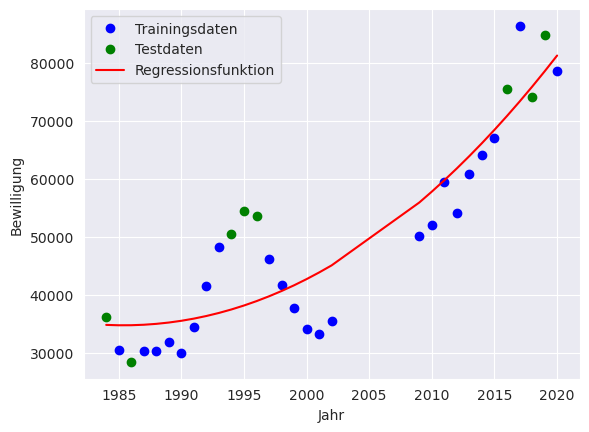

In [90]:
## Visualisieren Sie die Regressionsfunktion gemeinsam mit einem Scatterplot der beiden Merkmale
## "Jahr" und "Bewilligung" 
## Der Scatterplot soll die zum Trainieren verwendeten Daten, also aus 'df_flats' enthalten.
## Verwenden Sie für 
## - die Regressionsfunktion
## - die Trainingsdaten
## jeweils unterschiedliche Farben.
## 
## Speichern Sie eine Referenz auf den Plot in der Variable 'plot_preg_flats'

fx = preg_years.predict(polynom.transform(df_flats[[indi_feature]]))

plot_preg_flats = plt.plot(df_flats_train[indi_feature], df_flats_train[predict_feature], 'bo', label='Trainingsdaten')
plot_preg_flats = plt.plot(df_flats_test[indi_feature], df_flats_test[predict_feature], 'go', label='Testdaten')
plot_preg_flats = plt.plot(df_flats[indi_feature], fx, 'r', label='Regressionsfunktion')
plot_preg_flats = plt.xlabel(indi_feature) 
plot_preg_flats = plt.ylabel(predict_feature)
plot_preg_flats = plt.legend()

In [91]:
# hier gibt es leider keine brauchbaren Testfälle 
assert plot_preg_flats is not None

assert True


### Verschieben der "x"-Werte

Ein Bild sagt mehr als tausend Worte - wir sparen uns hier die Berechnung des R$^2$-Scores. Das entspricht nicht ganz unserer Vorstellung (oder zumindest jener des Beispielerstellers). Es ist zwar nicht ausgeschlossen, dass diese Funktion als langanhaltender Trend die Entwicklung gut abbildet, und gelegentliche Schwankungen in der Größenordnung von Jahrzehnten glättet, wir arbeiten trotzdem mit der Annahme weiter, dass wir die Entwicklungen lokal gerne besser abgebildet hätten, um eine genauere Vorhersage der fehlenden Jahre zu erreichen.

Was können wir tun? Nun, die Funktion verhält sich in diesem Abschnitt (1983-2020) absolut nicht so, wie wir uns ein Polynom vom Grad 6 vorstellen. Diese Kurve könnte uns ein Polynom vom Grad 2 vielleicht auch liefern. 
Wenn wir uns die Koeffizienten ansehen, dann erkennen wir dort sehr sehr kleine Werte (in der Größenordnung von $10^{-10}$). Das könnte ein Hinweis darauf sein, dass die Jahreszahlen einfach zu große Werte sind, um die Funktionswerte gut abzubilden. 

Im nächsten Schritt versuchen wir daher, die Jahre nicht durch ihre Jahreszahlen darzustellen, sondern sie durchzunummerieren. Das erste Jahr wird 0, das nächste Jahr wird 1, usw. Dabei behalten wir Lücken bei, d.h. für die fehlenden Jahre zählen wir trotzdem weiter. Die Frage bleibt, was wir als erstes Jahr sehen. Um für später gewappnet zu sein, beginnt unsere Zeitrechnung mit 1980 (das erste Jahr in unserem originalen Datensatz). Dieses Jahr, 1980 soll Jahr 0 werden, und von da an sollen die Jahre aufsteigend durchnummeriert werden. 

_Wichtig:_ kodieren Sie das Jahr 1980 nicht fix in Ihre Lösung, sondern berechnen Sie dies dynamisch aus den Werten in ```df_flats_raw```: die kleinste Jahreszahl dort soll Jahr 0 werden.

In [92]:
## Erstellen Sie eine Kopie des DataFrames 'df_flats', mit der selben Struktur 
## und der selben Anzahl an Zeilen. Die Werte aller Einträge soll ident zu den
## Einträgen in 'df_flats' sein, mit Ausnahme des Merkmals "Jahr": 
## Dieses soll so skaliert werden, dass die Zählung der Jahre mit dem 
## frühesten Jahr im DataFrame 'df_flats_raw' beginnt. 
## (Das ist 1980, d.h. 1980 wird das Jahr 0, 1981 das Jahr 1, usw., dies 
## darf jedoch nicht fix kodiert werden, sondern muss dynamisch aus den
## Daten berechnet werden.) 
##
## Die DataFrames 'df_flats' und 'df_flats_raw' dürfen nicht verändert werden.
## 
## Speichern Sie eine Referenz auf das neue DataFrame in der Variablen 
##    'df_flats_time'

df_flats_time = df_flats.copy()
df_flats_time['Jahr'] = [i - 1980 for i in df_flats['Jahr']]

df_flats_time

,Jahr,Fertigstellung,Bewilligung,Bewilligungen vor 1 Jahr,Bewilligungen vor 2 Jahren,Bewilligungen vor 3 Jahren,Bewilligungen vor 4 Jahren
0,4,37645,36263,36958,37516,41292,42334
1,5,37317,30568,36263,36958,37516,41292
2,6,34616,28483,30568,36263,36958,37516
3,7,34289,30338,28483,30568,36263,36958
4,8,34893,30348,30338,28483,30568,36263
5,9,32858,31946,30348,30338,28483,30568
6,10,31335,29987,31946,30348,30338,28483
7,11,34312,34414,29987,31946,30348,30338
8,12,34334,41548,34414,29987,31946,30348
9,13,35494,48231,41548,34414,29987,31946


In [93]:
cols = ["Fertigstellung", 
        "Bewilligung", 
        "Bewilligungen vor 1 Jahr",
        "Bewilligungen vor 2 Jahren",
        "Bewilligungen vor 3 Jahren",
        "Bewilligungen vor 4 Jahren"]

assert len(df_flats_time.index) == 31, f'Anzahl Zeilen im neuen DataFrame unerwartet: {len(df_flats_time.index)}'
assert (3 not in df_flats_time["Jahr"].values)
assert (4 in df_flats_time["Jahr"].values)
assert (40 in df_flats_time["Jahr"].values)
assert (41 not in df_flats_time["Jahr"].values)
assert (24 not in df_flats_time["Jahr"].values)

# prinzipiell Kopie?
assert (df_flats_time.sort_values("Jahr")[cols] == df_flats.sort_values("Jahr")[cols]).all().all(), f'Merkmale außer Jahr im neuen DF unerwartet'

# alte DFs nicht geändert
assert (1984 in df_flats["Jahr"].values), 'df_flats verändert?'
assert (1980 in df_flats_raw["Jahr"].values), 'df_flats raw verändert?'



Mit diesem veränderten Datensatz unternehmen wir einen neuen Anlauf.

f(x) = 0.0032421213982161134 * x^6 + -0.48543226067408796 * x^5 + 28.105784515074262 * x^4 + -787.9667204253209 * x^3 + 10987.196865887136 * x^2 + -69372.6362003068 * x + 184162.9854864946


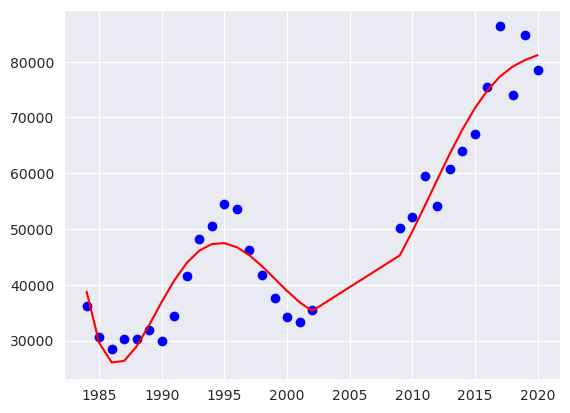

In [94]:
## Erstellen Sie ein polynomielles Regressionsmodell, um die Werte 
## von "Bewilligung" wiederum anhand der Werte von "Jahr" zu beschreiben -
## diesmal aber nicht nach den Jahreszahlen, sondern den seit 1980 
## vergangenen Jahren.
## 
## Gehen Sie wie in der Vorlesung gezeigt vor, d.h. verwenden Sie 
## ein lineares Modell das mit den durch 'polynom' transformierten 
## Daten arbeitet. Trainieren Sie das Modell mit den Daten aus 
##   'df_flats_time'.
## 
## Speichern Sie eine Referenz auf das Modell in der Variablen 'preg_time' ab.
## 
## Visualisieren Sie anschließend die berechenete Regressionsfunktion gemeinsam 
## mit einem Scatterplot der beiden Merkmale "Jahr" und "Bewilligung" 
## 
## Der Scatterplot soll die zum Trainieren verwendeten Daten, also aus 
##    'df_flats_time' enthalten.
## 
## Die x-Achse soll wie Werte aus diesem DataFrame abdecken.
## 
## Verwenden Sie für 
## - die Regressionsfunktion
## - die Trainingsdaten
## jeweils unterschiedliche Farben.
## 
## Speichern Sie eine Referenz auf den Plot in der Variable 'plot_preg_time'

indi_feature = "Jahr"
predict_feature = "Bewilligung"

preg_time = LinearRegression(fit_intercept=False)
preg_time.fit(X=polynom.fit_transform(df_flats_time[[indi_feature]]), y=df_flats_time[predict_feature])
fx = preg_time.predict(polynom.transform(df_flats_time[[indi_feature]]))

plot_preg_time = plt.plot(df_flats[indi_feature], df_flats[predict_feature], 'bo')
plot_preg_time = plt.plot(df_flats[indi_feature], fx, 'r')

# Ausgabe des Polynoms
val = lambda i : preg_time.coef_[0][i] if type(preg_time.coef_[0]) == np.ndarray else preg_time.coef_[i]
xterm = lambda i : f' * x^{i}' if i > 1 else (' * x' if i == 1 else '')
terms = [f'{val(i)}{xterm(i)}' for i in range(polynom.degree, -1, -1)]
print('f(x) =', ' + '.join(terms))
plot_preg_time

In [95]:
# Ein paar grundlegende Testfälle:
assert preg_time is not None, 'Die Variable preg_time wurde nicht initialisiert'

# Wir testen drei Vorhersagen:
val = lambda v, t : [v] if type(t) == np.ndarray else v
predictions = preg_time.predict(polynom.transform(pd.DataFrame(data={indi_feature: [7, 17, 19]})))
assert (predictions > [val(26359, predictions[0]), val(45283, predictions[0]), val(41121, predictions[0])]).all()

# Für die Grafik gibt es keine brauchbaren Testfälle:
assert plot_preg_time is not None


Das sieht schon besser aus. Hierfür berechnen wir nun den $R^2$-Score auf den Trainingsdaten.

In [96]:
## Berechnen Sie den R^2 Wert für die Trainingsdaten des Modells 
##   'preg_time' (auf dem Modell selber)
## und speichern Sie die Werte in der Variablen
## 'r2_poly'

r2_poly = r2_score(y_true=df_flats_time[predict_feature], y_pred=fx)

print(f'R^2 Score auf den Trainingsdaten: {r2_poly}')

R^2 Score auf den Trainingsdaten: 0.9400093808569935


In [97]:
assert r2_poly > 0.9, f'R2-Score ist unerwaretet gering'
assert r2_poly < 1, 'R2-Score ist unerwartet hoch'


### Test des Modells

Wir testen unser Modell nun, indem wir es auf den tatsächlich ungesehenen Werten anwenden: Die Jahre 2003-2008, wobei wir die Werte für die Jahre 2005-2008 mit den tatsächlichen Werten vergleichen werden.

Als Ausgang dient das folgende DataFrame, in dem die Daten bereits korrekt skaliert wurden.

In [98]:
df_unseen = pd.DataFrame({"Jahr": list(range(2003, 2009, 1))})
df_unseen = df_unseen.merge(df_flats_raw[["Jahr", "Bewilligung"]], how='left', left_on="Jahr", right_on="Jahr")
df_unseen["Jahr"] = [23, 24, 25, 26, 27, 28]  # ACHTUNG! SIE dürfen das NICHT so machen (wir dürfen das nur, um die korrekte Lösung nicht herzeigen zu müssen :-) )
df_unseen

,Jahr,Bewilligung
0,23,NaN
1,24,NaN
2,25,44546.0
3,26,48417.0
4,27,47673.0
5,28,48547.0


In [99]:
## Erstellen Sie ein DataFrame mit der selben Struktur und Idee wie 
##   'df_merror'
## also mit den Merkmalen "Jahr", "Bewilligung", "Vorhersage", 
##   "Abweichung", "Prozent"
## Erstellen Sie das DataFrame als Kopie von 'df_unseen' 
## ('df_unseen' darf nicht verändert werden), d.h. übernehmen Sie 
## die Werte für "Jahr" und "Bewilligung" von dort. 
## Berechnen Sie die übrigen Werte. 
## (Hinweis: für die Jahre 23 und 24 wird das Ergebnis wegen des 
## mangelnden Wertes für "Bewilligung" NaN sein - das ist in Ordnung.)
## 
## Speichern Sie eine Referenz auf das neue DataFrame in der Variablen
##  'df_gap_values'
##

val = lambda i : preg_time.coef_[0][i] if type(preg_time.coef_[0]) == np.ndarray else preg_time.coef_[i]
coef_list = [val(i) for i in range(polynom.degree, -1, -1)]

df_gap_values=df_unseen.copy()
df_gap_values["Vorhersage"] = df_gap_values.apply(
    lambda row: sum(coef * (row['Jahr'] ** i) for i, coef in enumerate(reversed(coef_list))),
    axis=1
)
df_gap_values["Abweichung"] = df_gap_values["Vorhersage"] - df_gap_values["Bewilligung"]
df_gap_values["Prozent"] = abs(df_gap_values["Abweichung"] / df_gap_values["Bewilligung"]) * 100


df_gap_values

,Jahr,Bewilligung,Vorhersage,Abweichung,Prozent
0,23,NaN,34321.042469,NaN,NaN
1,24,NaN,34082.410078,NaN,NaN
2,25,44546.0,34671.315054,-9874.684946,22.167389
3,26,48417.0,36124.668001,-12292.331999,25.388463
4,27,47673.0,38427.487936,-9245.512064,19.393602
5,28,48547.0,41514.175773,-7032.824227,14.486630


In [100]:
assert (df_gap_values[["Jahr", "Bewilligung"]][2:].sort_values("Jahr") == df_unseen[["Jahr", "Bewilligung"]][2:].sort_values("Jahr")).all().all(),\
        f'df_gap_values enthält nicht die erwarteten Jahre tatsächlichen Bewilligungen'
assert sorted(df_gap_values.columns) == ['Abweichung', 'Bewilligung', 'Jahr', 'Prozent', 'Vorhersage'], \
        f'df_gap_values besitzt nicht die geforderten Merkmale: {sorted(df_gap_values.columns)}'
assert int(df_gap_values[df_gap_values["Jahr"] == 27]["Vorhersage"].iloc[0]) == 38427, \
        f'Unerwartete Vorhersage für 27: {df_gap_values[df_gap_values["Jahr"] == 27]["Vorhersage"].iloc[0]}'
assert np.isnan(df_gap_values[df_gap_values["Jahr"] == 23]["Abweichung"].iloc[0]), \
        f'Unerwartete Vorhersage für 23: {df_gap_values[df_gap_values["Jahr"] == 23]["Vorhersage"].iloc[0]}'



Der Versuch, die Anzahl der Bewilligungen alleine aus der Zeit/dem Jahr abzuschätzen, war von Anfang an etwas fraglich. Die Tatsache, dass die Entwicklung der Bewilligungen eine relativ schöne Struktur besessen hat, und uns nur ein kleines "Loch" in der Mitte (und nicht am Anfang oder Ende) gefehlt hat, hat aber zumindest die Hoffnung offen gelassen, die Werte doch grob beschreiben zu können. 
Natürlich ist eine Abweichung von rund 20% (bei den bekannten Daten!) besser, als einfach irgendetwas zu raten. Eine genaue Vorhersage ist aber doch etwas anderes. 

Sie können gerne noch versuchen, das Modell zu verbessern - man könnte argumentieren, dass die aktuelle Funktion es nicht schafft den Verlauf der Daten exakt genug zu beschreiben (auch der Trainingsdaten). Achten Sie dabei jedoch auf mögliches Overfitting! Es ist immer etwas "gefährlich" ein Modell mit einem bekannten Ziel im Auge zu entwickeln. 

Für die uns in dieser Übung zur Verfügungen stehenden Zeit ist es jedoch ausreichend, dass wir ein polynomielles Regressionsmodell erstellt und analysiert haben.

## Ein Blick über den Tellerrand

Zum Abschluss des Übungsblattes wollen wir unsere beiden Modelle ```mreg_flats```  (multiple lineare Regression zur Beschreibung der Fertigstellungen basierend auf den Bewilligungen der letzten vier Jahre) und ```preg_time``` (polynomielle Regression zur Beschreibung der Bewilligungen basierend auf der Zeit) noch einmal auf ungesehenen (neuen) Daten ausprobieren. 

Für das Modell zur Beschreibung der Fertigstellungen sind dies die Zahlen für die Jahre 2021, 2022 und 2023 (aus Sicht der Modells also "die Zukunft"). Die Daten selber stammen wiederum von der Statistik Austria (selbe Quelle wie die anderen Datensätze), werden dort aber teilweise noch als "aufgeschätzt" geführt, da die Zahlen aus diversen Jahren selber erst einzutreffen scheinen. Für 2023 gibt es aktuell noch keine Zahlen zu den Fertigstellungen. Wir lassen dieses Jahr also mit 0 Fertigstellungen noch offen - schauen Sie, was Ihr Modell für 2023 vorhersagt.

Die Daten sind in folgendem DataFrame bereits aufbereitet.

In [101]:
df_future = pd.DataFrame({"Jahr": [2021, 2022, 2023], 
                          "Bewilligung": [78758, 64194, 46565], 
                          "Fertigstellung": [73162, 77346, 0],
                          "Bewilligungen vor 1 Jahr": [78474, 78758, 64194],
                          "Bewilligungen vor 2 Jahren": [84822, 78474, 78758],
                          "Bewilligungen vor 3 Jahren": [74046, 84822, 78474],
                          "Bewilligungen vor 4 Jahren": [86312, 74046, 84822],
                         })
df_future

,Jahr,Bewilligung,Fertigstellung,Bewilligungen vor 1 Jahr,Bewilligungen vor 2 Jahren,Bewilligungen vor 3 Jahren,Bewilligungen vor 4 Jahren
0,2021,78758,73162,78474,84822,74046,86312
1,2022,64194,77346,78758,78474,84822,74046
2,2023,46565,0,64194,78758,78474,84822


Für das Modell zur Beschreibung der Bewilligungen sind dies neben den Werten aus den Jahren 2021, 2022, 2023 auch die Werte aus den Jahren 1980-1983. Es handelt sich hier also um Werte an den "Rändern" des Modells, nicht wie zuvor aus der "Mitte".

Die Daten sind in folgendem DataFrame aufbereitet (die Jahre wurden bereits auf die richtigen - entsprechend den Aufgabenstellungen im Rahmen der polynomiellen Regression - Werte skaliert).

In [102]:
df_helper = pd.DataFrame({"Jahr": list(range(1980, 1984, 1))})
df_border_cases = df_helper.merge(df_flats_raw[["Jahr", "Bewilligung"]], how='left', left_on="Jahr", right_on="Jahr")
df_border_cases = pd.concat([df_border_cases, df_future[["Jahr", "Bewilligung"]]])
df_border_cases["Jahr"] = [0, 1, 2, 3, 41, 42, 43]  # ACHTUNG! SIE dürfen das NICHT so machen (wir dürfen das nur, um die korrekte Lösung nicht herzeigen zu müssen :-) )
df_border_cases.reset_index(inplace=True, drop=True)

df_border_cases

,Jahr,Bewilligung
0,0,42334
1,1,41292
2,2,37516
3,3,36958
4,41,78758
5,42,64194
6,43,46565


Bevor Sie die Modelle auf die Jahre anwenden, überlegen Sie sich zuerst für beide Modelle, ob Sie ein gutes oder eher nicht so gutes Ergebnis erwarten. 

(keine Eingabe erforderlich)

In [103]:
## Erweitern Sie das unten erstellte DataFrame 'df_future_error' 
## auf die selbe Struktur wie 'df_merror', d.h. fügen Sie die 
## Merkmale "Vorhersage", "Abweichung", "Prozent" 
## hinzu und berechnen Sie die entsprechenden Werte 
##
## Hinweis: da für 2023 der Wert für die Fertigstellung 0 
##  ist, gibt es keinen sinnvollen Prozentsatz. Sie brauchen
##  dies nicht extra betrachten. Die normale Berechnung sollte 
##  in dem Fall inf ergeben.

indi_features = ["Bewilligung", 
                 "Bewilligungen vor 1 Jahr", 
                 "Bewilligungen vor 2 Jahren",
                 "Bewilligungen vor 3 Jahren",
                 "Bewilligungen vor 4 Jahren"]
predict_feature = "Fertigstellung"

mreg_flats.predict(df_flats[[feature for feature in indi_features]])

df_future_error = df_future[["Jahr", "Fertigstellung"]].copy()
df_future_error["Vorhersage"] = df_future.apply(
    lambda row: sum(mreg_flats.coef_[idx] * row[feature] for idx, feature in enumerate(indi_features)) + mreg_flats.intercept_,
    axis=1
)
df_future_error["Abweichung"]= df_future_error["Vorhersage"] - df_future_error["Fertigstellung"]
df_future_error["Prozent"] = abs(df_future_error["Abweichung"] / df_future_error["Fertigstellung"]) * 100

df_future_error

,Jahr,Fertigstellung,Vorhersage,Abweichung,Prozent
0,2021,73162,75663.109798,2501.109798,3.418591
1,2022,77346,67170.035505,-10175.964495,13.156420
2,2023,0,68291.825844,68291.825844,inf


In [104]:
## Erweitern Sie das DataFrame 'df_border_error' auf die 
## selbe Struktur wie 'df_gap_values', d.h. fügen Sie die 
## Merkmale "Vorhersage", "Abweichung", "Prozent" 
## hinzu und berechnen Sie die entsprechenden Werte 
##

df_border_error = df_border_cases.copy()

df_border_error["Vorhersage"] = df_border_error.apply(
    lambda row: sum(coef*((row['Jahr'])**i) for i, coef in enumerate(reversed(coef_list))),
    axis=1
)
df_border_error["Abweichung"]= df_border_error["Vorhersage"] - df_border_error["Bewilligung"]
df_border_error["Prozent"] = abs(df_border_error["Abweichung"] / df_border_error["Bewilligung"]) * 100
df_border_error

,Jahr,Bewilligung,Vorhersage,Abweichung,Prozent
0,0,42334,184162.985486,141828.985486,335.023824
1,1,41292,125017.203026,83725.203026,202.763739
2,2,37516,83497.133002,45981.133002,122.564061
3,3,36958,55815.719240,18857.719240,51.024729
4,41,78758,82215.290459,3457.290459,4.389764
5,42,64194,84073.478714,19879.478714,30.967814
6,43,46565,87666.382351,41101.382351,88.266686


In [105]:
# richtigen Merkmale
assert sorted(df_future_error.columns) == ['Abweichung', 'Fertigstellung', 'Jahr', 'Prozent', 'Vorhersage'], \
        f'unerwartete Merkmale in df_future_error: {sorted(df_future_error.columns)}'
assert sorted(df_border_error.columns) == ['Abweichung', 'Bewilligung', 'Jahr', 'Prozent', 'Vorhersage'], \
        f'unerwartete Merkmale in df_future_error: {sorted(df_border_error.columns)}'

# richtige Anzahl an Zeilen
assert len(df_future_error.index) == 3
assert len(df_border_error.index) == 7

# ein paar Werte testweise
assert int(df_future_error[df_future_error["Jahr"]==2022]["Vorhersage"].iloc[0]) == 67170
assert np.isinf(df_future_error[df_future_error["Jahr"]==2023]["Prozent"].iloc[0])
assert int(df_border_error[df_border_error["Jahr"]==42]["Abweichung"].iloc[0]) == 19879




Entspricht das Ergebnis bzgl. was funktioniert gut und was funktioniert schlecht Ihren Erwartungen? Fallen Ihnen Erklärungen ein, warum sich die Qualität der Vorhersagen so verhält wie sie es tut?

Wenn Sie die Ergebnisse besser verstehen wollen (vor allem bei der polynomiellen Regression), können Sie natürlich einen weiteren Plot anfertigen mit den neuen Daten "am Rand". Wir fordern dies aber nicht mehr von Ihnen sondern beenden das Übungsblatt hiermit.

## Ende

Damit haben Sie das 3. Übungsblatt fertig durchgearbeitet. Gratulation :) Bitte melden Sie sich bei Fragen, Problemen oder Unklarheiten rechtzeitig.